<a href="https://colab.research.google.com/github/LuyueChang/Project/blob/main/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

#IP: additional libraries for the prediction models
from numpy import sum as arraysum
from numpy import sqrt
from scipy import stats
from sklearn.utils import shuffle
from scipy import stats
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
os.chdir('/content/drive/MyDrive/Project')
adapt_data = pd.read_csv('adapt_data.csv')
adapt_data_sample_size = pd.read_csv('adapt_data_sample_size.csv')

Mounted at /content/drive


# Adapt function

In [46]:
def adapt(T,S,A,algo):
  # Updated this function to work for all CF algorithms, not just NMF; the algoritms can be specified through the algo parameter; see examples below
  S_last = S
  S_final = S
  S_step_3 = S
  S_loop = S
  S_while = S
  time_budget_schedule = T
  baseline_list = []
  shuffled_data = adapt_data_sample_size.sample(frac = 1)
  # Get needed data from csv and name it indexed_new_df
  group_sample_size = shuffled_data.loc[:,['sample_size', algo]].groupby(['sample_size']).count()
  # Combine the counted number with the previous csv and rename the column
  group_sample_size_count = shuffled_data.merge(group_sample_size,on='sample_size',left_index=True).sort_values("sample_size")
  group_sample_size_count.rename(columns={algo+'_x':algo, algo+'_y':'sub_samples'},inplace=True)
  # Create a new dataframe contains nmf\sample_size\sub_samples column
  new_df = group_sample_size_count.loc[:,[algo,'sample_size','sub_samples']]
  # Reset index of the dataframe and delete original index
  indexed_new_df = new_df.reset_index(drop=True)
  # print('indexed_new_df',indexed_new_df)
  
  # Make a prediction dictionary according to the first value of S
  update_s = indexed_new_df[indexed_new_df['sample_size']==S]['sub_samples'].iloc[0]
  predict_base = indexed_new_df[algo][S-update_s]
  # print('predict_base:',predict_base)
  
  predict_first = predict_base
  key = []
  value = []
  value.append(predict_base)

  while S > 0:
    key.append(S)
    predict_value = predict_base*(S-update_s)/S
    value.append(predict_value)
    S -= update_s
    predict_base = predict_value
  value.pop()
  predicted_dic = dict(zip(key,value))

  # Compute schedule 
  baseline = predicted_dic[list(predicted_dic.keys())[-1]]
  baseline_list.append(baseline)
  # The time_budget here is defined by T minus first subsample of S
  time_budget = T - predict_first
  # In the loop, the first S and the other S is different
  p_key = []
  for k in predicted_dic.keys():
    p_key.append(k)
  p_key.pop(0)

  # fill schedule
  actual_dic = {}
  i = 1
  time_budget2 = time_budget
  while time_budget2 > baseline:
    actual_dic[S_step_3] = i
    if i >= 2:
      time_budget2 -= predicted_dic[S_step_3]
    # if time_budget>0,the number of subsamples will add 1,else minus 1
      for j in p_key:
        time_budget2 -= predicted_dic[j]
        if time_budget2 >= 0:
          actual_dic[j] = i
        else:
          actual_dic[j] = i-1
      i += 1
    else:
      for j in p_key:
        time_budget2 -= predicted_dic[j]
        if time_budget2 >= 0:
          actual_dic[j] = i
        else:
          actual_dic[j] = i-1
      i += 1


  for k in actual_dic.keys():
    # if number of sub-samples is bigger than the total number of sub-samples then we set it as the total number of sub-sample. 
    if actual_dic[k] > indexed_new_df[indexed_new_df['sample_size']==k]['sub_samples'].iloc[0]:
      actual_dic[k] = indexed_new_df[indexed_new_df['sample_size']==k]['sub_samples'].iloc[0]

  # compute time_budget by real values from csv according to schedule
  for key,value in actual_dic.items():
    time_budget_schedule -= np.sum(indexed_new_df[indexed_new_df['sample_size']==key][0:value][algo])

  # Play out computed schedule 
  # make an accuracy dictionary
  accuracy = 0
  acc_dic = {}
  actual_dictionary = {}
  for i,j in actual_dic.items():
    current_time_list = []
    for p in range(0,j):
      # while accuracy < acc :
      current_time_list.append(indexed_new_df[indexed_new_df['sample_size']==i][algo].iloc[p])
      actual_dictionary[i] = current_time_list
      acc_dic[i] = np.std(actual_dictionary[i])/np.mean(actual_dictionary[i])
      if p >= 2 and acc_dic[i] <= A:
       actual_dic[i] = p + 1;
       break


  # update prediction dictionary
  key = []
  value = []
  # get the maximum of the first list in the actual_dictionary
  predict_new = max(actual_dictionary[S_final])
  value.append(predict_new)
  S_last = S_final
  while S_last > 0:
    key.append(S_last)
    predict_value = predict_new*(S_last-update_s)/S_last
    value.append(predict_value)
    S_last -= update_s
    predict_new = predict_value
  value.pop()
  predicted_dic = dict(zip(key,value))
  baseline = predicted_dic[list(predicted_dic.keys())[-1]]
  time_budget_schedule_list = []
  while time_budget_schedule > baseline and len(time_budget_schedule_list)==len(set(time_budget_schedule_list)):
    S_loop = S_while
    while S_loop > 0:
      for i,j in acc_dic.items():
        if acc_dic[i] > A:
          if time_budget_schedule >= predicted_dic[S_loop]:
            actual_dic[S_loop] += 1
            time_budget_schedule -= predicted_dic[S_loop]
            S_loop -= indexed_new_df[indexed_new_df['sample_size']==S_loop]['sub_samples'].iloc[0]
          else:
            S_loop -= indexed_new_df[indexed_new_df['sample_size']==S_loop]['sub_samples'].iloc[0]
        else:
          actual_dic[S_loop] += 0
          time_budget_schedule -= 0
          S_loop -= indexed_new_df[indexed_new_df['sample_size']==S_loop]['sub_samples'].iloc[0]

    for k in actual_dic.keys():
      # if number of sub-samples is bigger than the total number of sub-samples
      # then we set it as the total number of sub-sample. 
      if actual_dic[k] > indexed_new_df[indexed_new_df['sample_size']==k]['sub_samples'].iloc[0]:
        actual_dic[k] = indexed_new_df[indexed_new_df['sample_size']==k]['sub_samples'].iloc[0]

    schedule_keys = []
    for schedule_key in actual_dic.keys():
      schedule_keys.append(schedule_key)

    if len(set(actual_dic.values())) == 1:
      different_S = S_while
    else:
      prep_i = []
      for i in range(0,len(schedule_keys)):
        if actual_dic[schedule_keys[i]] != actual_dic[schedule_keys[i-1]]:
          prep_i.append(i)
        else:
          different_S = S_while
      different_S = schedule_keys[prep_i[1]]

    actual_dictionary = {}
    for i,j in actual_dic.items():
      current_time_list = []
      for p in range(0,j):
        current_time_list.append(indexed_new_df[indexed_new_df['sample_size']==i][algo].iloc[p])
        actual_dictionary[i] = current_time_list
        acc_dic[i] = np.std(actual_dictionary[i])/np.mean(actual_dictionary[i])
        if p >= 2 and acc_dic[i] <= A:
          actual_dic[i] = p + 1
          break

    # print('acc',acc_dic)
    time_budget_schedule_loop = T
    for key,value in actual_dic.items():
      time_budget_schedule_loop -= np.sum(indexed_new_df[indexed_new_df['sample_size']==key][0:value][algo])

    # update prediction dictionary
    key = []
    value = []
    # get the maximum of the first list in the actual_dictionary
    predict_new = max(actual_dictionary[S_final])
    value.append(predict_new)
    S_last = S_final
    while S_last > 0:
      key.append(S_last)
      predict_value = predict_new*(S_last-update_s)/S_last
      value.append(predict_value)
      S_last -= update_s
      predict_new = predict_value
    value.pop()
    predicted_dic = dict(zip(key,value))

    # update baseline
    baseline = predicted_dic[list(predicted_dic.keys())[-1]]
    # update time budget
    time_budget_schedule = time_budget_schedule_loop
    time_budget_schedule_list.append(time_budget_schedule)
  print('The final shedule',actual_dic)
  print('The final actual_dictionary:',actual_dictionary)
  # Updated this code to return the proposed schedule and the corresponding runtimes
  return actual_dictionary

In [47]:
adapt(60,40,0.001,'svd')

The final shedule {40: 5, 30: 3, 20: 3, 10: 3}
The final actual_dictionary: {40: [7.700385000000001, 7.667486, 7.886412, 7.827156, 7.735369], 30: [4.252987, 4.293346, 4.242529], 20: [1.752802, 1.744201, 1.8699849999999998], 10: [0.47936999999999996, 0.451603, 0.5216649999999999]}


{10: [0.47936999999999996, 0.451603, 0.5216649999999999],
 20: [1.752802, 1.744201, 1.8699849999999998],
 30: [4.252987, 4.293346, 4.242529],
 40: [7.700385000000001, 7.667486, 7.886412, 7.827156, 7.735369]}

# Complexity

In [42]:
#IP: here is a helper function to get the number of users (m), items (n), ratings (r) from the complete dataset (df) 
def get_m_n_r_complete_dataset(df):
  m = []; n = []; r = [];
  for i in range(0, 100, 10):
    m.append(df[i:i+1]['m'].to_list()[0])
    n.append(df[i:i+1]['n'].to_list()[0])
    r.append(df[i:i+1]['r'].to_list()[0])
  return (m, n, r)

#IP: get the actual runtimes for the complete dataset (df) for all CF algorithms; these are stored as a map where the key is the name of the algorithm and the value is the actual runtime
def get_actual_runtime_complete_dataset(df):
  actual_runtime = {}
  algorithms = ['baseline', 'random', 'nmf', 'svd', 'coclustering', 'slopeone', 'knn', 'knnbaseline', 'centredknn']
  for a in algorithms:
    actual_runtime[a] = df[90:100][a].mean()
  return actual_runtime

#IP: below are some helper functions to compute the complexity of various CF based on the number of users (m), items (n), ratings (r) 
def comp_baseline(m, n, r):
    return (m*m + n*n)

def comp_random(m, n, r):
    return r

def comp_slopeone(m, n, r):
    return (n*n + (r*r)/m + r)

def comp_nmf(m, n, r):
    return (r + m + n)

def comp_svd(m, n, r):
    return r

def comp_knn(m, n, r):
    return (n*n +r*r/n) # this is for item-based KNN

def comp_centred_knn(m, n, r):
    return (n*n +r*r/n + r) #item-based centred KNN

def comp_coclustering(m, n, r):
    return (m + n + r)

def comp_knn_baseline(m, n, r):
    return (n*n +r*r/n + r)

# NRMSE

In [43]:
#IP: get the number of users (m), items (n), ratings (r) for each sample size 
m, n, r = get_m_n_r_complete_dataset(adapt_data_sample_size)
#IP: get the actual runtime of the algorithms on the complete dataset
actual_rt = get_actual_runtime_complete_dataset(adapt_data_sample_size)

In [44]:
#IP: this function predicts the overall runtime of a CF (algo), based on linear models which learn the slope and intercept of the curves computed using the time complexity equations for the various CF models
def predict_time(algo, m, n, r, adapt_schedule, actual_runtime, algo_complexity):
  df = pd.DataFrame(columns=['s', 'm', 'n', 'r', algo])
  s_list = []; m_list = []; n_list = []; r_list = []; t_list = [];
  predictions = []; norm_rmse = [];

  # IP: build the dataframe with users, items, ratings, runtimes for the linear models
  for k,v in adapt_schedule.items():
    s_list += [k] * len(v)
    m_list += [m[int(k/10)]-1] * len(v)
    n_list += [n[int(k/10)]-1] * len(v)
    r_list += [r[int(k/10)]-1] * len(v)
    t_list += v
  df['s'] = s_list; df['m'] = m_list; df['n'] = n_list; df['r'] = r_list; df[algo] = t_list;
  df = df.sort_values(by=['s'])
  # df是按照adapt函数取出来的actual_dictionary取的对应的m,n,r和实际运行时间
  # print('df',df)

  # IP: get the samples sizes and sort them in ascending order (in Luyue's dataframe are from 100% to 10%)
  sample_sizes = list(adapt_schedule.keys())
  sample_sizes.sort()

  #IP: for every sample size, we compute slope and intercept based on the previous runtimes and complexity equations
  for sample in range(1, len(sample_sizes)):
    #IP: slice original dataframe, such that we get the samples from x% + (x+10)%, then x% + (x+10)% + (x+20)%, and so on, where smallest x can be 10%
    temp_df = df.loc[df['s'] <= sample_sizes[sample]]
    m_array = np.array(temp_df[0:len(temp_df)-1]['m'].to_list())
    n_array = np.array(temp_df[0:len(temp_df)-1]['n'].to_list())
    r_array = np.array(temp_df[0:len(temp_df)-1]['r'].to_list())

    #IP: compute slope and intercept using least squares regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(algo_complexity(m_array, n_array, r_array), temp_df[0:len(temp_df)-1][algo].to_list())
    #IP: compute the predicted runtime of a specific CF on the full dataset based on slope and intercept learnt using the runtimes from the schedule
    predicted_runtime = intercept + (algo_complexity(m[-1], n[-1], r[-1]))*slope
    #IP: compute the normalised RMSE on the predictions
    nrmse = mean_squared_error([actual_runtime[algo]], [predicted_runtime], squared=False)/actual_runtime[algo]
    # nrmse = np.sqrt(mean_squared_error([actual_runtime[algo]], [predicted_runtime]))/actual_runtime[algo]
    predictions.append(predicted_runtime)
    norm_rmse.append(nrmse)
  #IP: create a dataframe with the predicted runtimes and normalised RMSEs on the full dataset based on different samples sizes
  predictions_df = pd.DataFrame()
  predictions_df['sample_size'] = sample_sizes[1:]
  predictions_df['predicted_runtime_full_dataset'] = predictions
  predictions_df['normalised_rmse'] = norm_rmse
  return predictions_df

# Experiments 

### different accuracy thresholds

##### svd model

In [52]:
a1 = adapt(60,40,0.001,'svd')
p1 = predict_time('svd', m, n, r, a1, actual_rt, comp_svd)
print('p1',p1)

a2 = adapt(60,40,0.005,'svd')
p2 = predict_time('svd', m, n, r, a2, actual_rt, comp_svd)
print('p2',p2)

a3 = adapt(60,40,0.01,'svd')
p3 = predict_time('svd', m, n, r, a3, actual_rt, comp_svd)
print('p3',p3)

a4 = adapt(60,40,0.1,'svd')
p4 = predict_time('svd', m, n, r, a4, actual_rt, comp_svd)
print('p4',p4)


The final shedule {40: 5, 30: 3, 20: 3, 10: 3}
The final actual_dictionary: {40: [7.69642, 7.683012, 7.735369, 7.667486, 7.691066999999999], 30: [4.496131, 4.252987, 4.771704], 20: [1.752802, 1.744201, 1.8205310000000001], 10: [0.47322700000000006, 0.484204, 0.465924]}
p1    sample_size  predicted_runtime_full_dataset  normalised_rmse
0           20                       24.042571         0.495912
1           30                       31.562501         0.338246
2           40                       34.688950         0.272695
The final shedule {40: 5, 30: 3, 20: 3, 10: 3}
The final actual_dictionary: {40: [7.683012, 7.700385000000001, 7.886412, 7.593894000000001, 7.69642], 30: [4.158374, 4.151807, 4.231962], 20: [1.8204349999999998, 1.7846090000000001, 1.887304], 10: [0.47322700000000006, 0.5216649999999999, 0.467013]}
p2    sample_size  predicted_runtime_full_dataset  normalised_rmse
0           20                       24.817017         0.479675
1           30                       29.8

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(18,5),dpi=80)
# plt.figure(1)

# ax1 = plt.subplot(141)
# ax1.set_title('accuracy=0.001')
# plt.plot(p1['sample_size'],p1['normalised_rmse'],color='red',label='accuracy=0.001')
# ax1.set_xlabel('Sample size')
# ax1.set_ylabel('NRMSE')

# ax2 = plt.subplot(142)
# ax2.set_title('accuracy=0.005')
# plt.plot(p2['sample_size'],p2['normalised_rmse'],color='green',label='accuracy=0.005')
# ax2.set_xlabel('Sample size')
# ax2.set_ylabel('NRMSE')

# ax3 = plt.subplot(143)
# ax3.set_title('accuracy=0.01')
# plt.plot(p3['sample_size'],p3['normalised_rmse'],color='blue',label='accuracy=0.01')
# ax3.set_xlabel('Sample size')
# ax3.set_ylabel('NRMSE')

# ax4 = plt.subplot(144)
# ax4.set_title('accuracy=0.1')
# plt.plot(p4['sample_size'],p4['normalised_rmse'],color='orange',label='accuracy=0.1')
# ax4.set_xlabel('Sample size')
# ax4.set_ylabel('NRMSE')

# plt.suptitle('S=40,T=60,CF model=svd')
# plt.show()

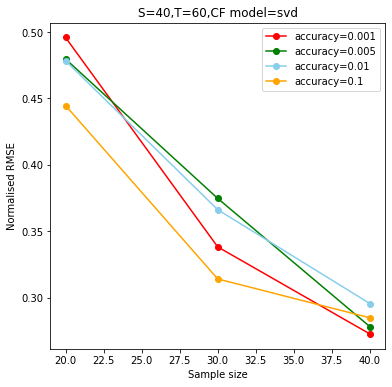

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(p1['sample_size'],p1['normalised_rmse'],color='red',label='accuracy=0.001',marker='o')
plt.plot(p2['sample_size'],p2['normalised_rmse'],color='green',label='accuracy=0.005',marker='o')
plt.plot(p3['sample_size'],p3['normalised_rmse'],color='skyblue',label='accuracy=0.01',marker='o')
plt.plot(p4['sample_size'],p4['normalised_rmse'],color='orange',label='accuracy=0.1',marker='o')
plt.xlabel('Sample size')
plt.ylabel('Normalised RMSE')
plt.title('S=40,T=60,CF model=svd')
plt.legend()
plt.show()

##### baseline model

In [9]:
a1_baseline = adapt(4,40,0.001,'baseline')
p1_baseline = predict_time('baseline', m, n, r, a1_baseline, actual_rt, comp_baseline)
print('p1_baseline',p1_baseline)

a2_baseline = adapt(4,40,0.005,'baseline')
p2_baseline = predict_time('baseline', m, n, r, a2_baseline, actual_rt, comp_baseline)
print('p2_baseline',p2_baseline)

a3_baseline = adapt(4,40,0.01,'baseline')
p3_baseline = predict_time('baseline', m, n, r, a3_baseline, actual_rt, comp_baseline)
print('p3_baseline',p3_baseline)

a4_baseline = adapt(4,40,0.1,'baseline')
p4_baseline = predict_time('baseline', m, n, r, a4_baseline, actual_rt, comp_baseline)
print('p4_baseline',p4_baseline)

The final shedule {40: 7, 30: 5, 20: 6, 10: 6}
The final actual_dictionary: {40: [0.365433, 0.365583, 0.359935, 0.366079, 0.365008, 0.366183, 0.360799], 30: [0.12925899999999999, 0.130385, 0.13132, 0.129436, 0.13172999999999999], 20: [0.09908600000000001, 0.098606, 0.098544, 0.099173, 0.099478, 0.10008500000000001], 10: [0.018813, 0.018941999999999997, 0.019656, 0.019617, 0.019672, 0.019293]}
p1_baseline    sample_size  predicted_runtime_full_dataset  normalised_rmse
0           20                        1.594152         0.375195
1           30                        0.948774         0.628142
2           40                        1.529383         0.400580
The final shedule {40: 7, 30: 6, 20: 3, 10: 10}
The final actual_dictionary: {40: [0.365433, 0.365583, 0.359935, 0.366079, 0.365008, 0.366183, 0.360799], 30: [0.12925899999999999, 0.130385, 0.13132, 0.129436, 0.13172999999999999, 0.128729], 20: [0.09908600000000001, 0.098606, 0.098544], 10: [0.018813, 0.018941999999999997, 0.019656, 0

In [ ]:
# plt.figure(figsize=(18,5),dpi=80)
# plt.figure(1)

# ax1 = plt.subplot(141)
# ax1.set_title('accuracy=0.001')
# plt.plot(p1_baseline['sample_size'],p1_baseline['normalised_rmse'],color='red',label='accuracy=0.001')
# ax1.set_xlabel('Sample size')
# ax1.set_ylabel('NRMSE')

# ax2 = plt.subplot(142)
# ax2.set_title('accuracy=0.005')
# plt.plot(p2_baseline['sample_size'],p2_baseline['normalised_rmse'],color='green',label='accuracy=0.005')
# ax2.set_xlabel('Sample size')
# ax2.set_ylabel('NRMSE')

# ax3 = plt.subplot(143)
# ax3.set_title('accuracy=0.01')
# plt.plot(p3_baseline['sample_size'],p3_baseline['normalised_rmse'],color='blue',label='accuracy=0.01')
# ax3.set_xlabel('Sample size')
# ax3.set_ylabel('NRMSE')

# ax4 = plt.subplot(144)
# ax4.set_title('accuracy=0.1')
# plt.plot(p4_baseline['sample_size'],p4_baseline['normalised_rmse'],color='orange',label='accuracy=0.1')
# ax4.set_xlabel('Sample size')
# ax4.set_ylabel('NRMSE')

# plt.suptitle('S=40,T=60,CF model=baseline')
# plt.show()

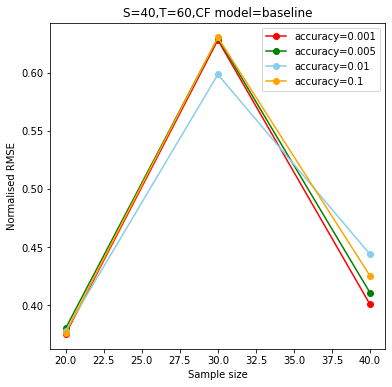

In [10]:
plt.figure(figsize=(6,6))
plt.plot(p1_baseline['sample_size'],p1_baseline['normalised_rmse'],color='red',label='accuracy=0.001',marker='o')
plt.plot(p2_baseline['sample_size'],p2_baseline['normalised_rmse'],color='green',label='accuracy=0.005',marker='o')
plt.plot(p3_baseline['sample_size'],p3_baseline['normalised_rmse'],color='skyblue',label='accuracy=0.01',marker='o')
plt.plot(p4_baseline['sample_size'],p4_baseline['normalised_rmse'],color='orange',label='accuracy=0.1',marker='o')
plt.xlabel('Sample size')
plt.ylabel('Normalised RMSE')
plt.title('S=40,T=60,CF model=baseline')
plt.legend()
plt.show()

##### NMF model

In [11]:
a1_nmf = adapt(60,40,0.001,'nmf')
p1_nmf = predict_time('nmf', m, n, r, a1_nmf, actual_rt, comp_nmf)
print('p1_nmf',p1_nmf)

a2_nmf = adapt(60,40,0.005,'nmf')
p2_nmf = predict_time('nmf', m, n, r, a2_nmf, actual_rt, comp_nmf)
print('p2_nmf',p2_nmf)

a3_nmf = adapt(60,40,0.01,'nmf')
p3_nmf = predict_time('nmf', m, n, r, a3_nmf, actual_rt, comp_nmf)
print('p3_nmf',p3_nmf)

a4_nmf = adapt(60,40,0.1,'nmf')
p4_nmf = predict_time('nmf', m, n, r, a4_nmf, actual_rt, comp_nmf)
print('p4_nmf',p4_nmf)

The final shedule {40: 4, 30: 5, 20: 4, 10: 3}
The final actual_dictionary: {40: [8.050094999999999, 7.546710000000001, 7.538053, 7.454207000000001], 30: [3.8059559999999997, 3.9692199999999995, 3.8635129999999998, 3.9523589999999995, 4.046638], 20: [1.7026009999999998, 1.660134, 1.7023580000000003, 1.655218], 10: [0.459082, 0.463218, 0.456826]}
p1_nmf    sample_size  predicted_runtime_full_dataset  normalised_rmse
0           20                       23.003463         0.512695
1           30                       28.277077         0.400979
2           40                       33.829630         0.283354
The final shedule {40: 4, 30: 5, 20: 4, 10: 2}
The final actual_dictionary: {40: [8.050094999999999, 7.546710000000001, 7.538053, 7.454207000000001], 30: [3.8059559999999997, 3.9692199999999995, 3.8635129999999998, 3.9523589999999995, 4.046638], 20: [1.7026009999999998, 1.660134, 1.7023580000000003, 1.655218], 10: [0.459082, 0.463218]}
p2_nmf    sample_size  predicted_runtime_full_datas

In [ ]:
# plt.figure(figsize=(18,5),dpi=80)
# plt.figure(1)

# ax1 = plt.subplot(141)
# ax1.set_title('accuracy=0.001')
# plt.plot(p1_nmf['sample_size'],p1_nmf['normalised_rmse'],color='red',label='accuracy=0.001')
# ax1.set_xlabel('Sample size')
# ax1.set_ylabel('NRMSE')

# ax2 = plt.subplot(142)
# ax2.set_title('accuracy=0.005')
# plt.plot(p2_nmf['sample_size'],p2_nmf['normalised_rmse'],color='green',label='accuracy=0.005')
# ax2.set_xlabel('Sample size')
# ax2.set_ylabel('NRMSE')

# ax3 = plt.subplot(143)
# ax3.set_title('accuracy=0.01')
# plt.plot(p3_nmf['sample_size'],p3_nmf['normalised_rmse'],color='blue',label='accuracy=0.01')
# ax3.set_xlabel('Sample size')
# ax3.set_ylabel('NRMSE')

# ax4 = plt.subplot(144)
# ax4.set_title('accuracy=0.1')
# plt.plot(p4_nmf['sample_size'],p4_nmf['normalised_rmse'],color='orange',label='accuracy=0.1')
# ax4.set_xlabel('Sample size')
# ax4.set_ylabel('NRMSE')

# plt.suptitle('S=40,T=60,CF model=NMF')
# plt.show()

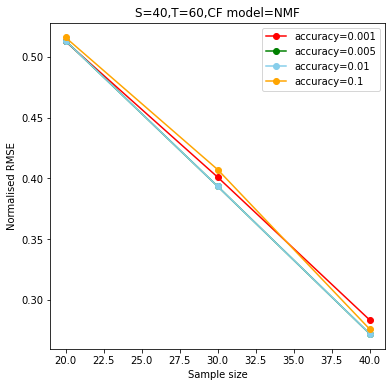

In [12]:
plt.figure(figsize=(6,6))
plt.plot(p1_nmf['sample_size'],p1_nmf['normalised_rmse'],color='red',label='accuracy=0.001',marker='o')
plt.plot(p2_nmf['sample_size'],p2_nmf['normalised_rmse'],color='green',label='accuracy=0.005',marker='o')
plt.plot(p3_nmf['sample_size'],p3_nmf['normalised_rmse'],color='skyblue',label='accuracy=0.01',marker='o')
plt.plot(p4_nmf['sample_size'],p4_nmf['normalised_rmse'],color='orange',label='accuracy=0.1',marker='o')
plt.xlabel('Sample size')
plt.ylabel('Normalised RMSE')
plt.title('S=40,T=60,CF model=NMF')
plt.legend()
plt.show()

##### coclustering model

In [13]:
a1_co = adapt(60,40,0.001,'coclustering')
p1_co = predict_time('coclustering', m, n, r, a1_co, actual_rt, comp_coclustering)
print('p1_co',p1_co)

a2_co = adapt(60,40,0.005,'coclustering')
p2_co = predict_time('coclustering', m, n, r, a2_co, actual_rt, comp_coclustering)
print('p2_co',p2_co)

a3_co = adapt(60,40,0.01,'coclustering')
p3_co = predict_time('coclustering', m, n, r, a3_co, actual_rt, comp_coclustering)
print('p3_co',p3_co)

a4_co = adapt(60,40,0.1,'coclustering')
p4_co = predict_time('coclustering', m, n, r, a4_co, actual_rt, comp_coclustering)
print('p4_co',p4_co)

The final shedule {40: 10, 30: 10, 20: 10, 10: 10}
The final actual_dictionary: {40: [2.6041279999999998, 2.606566, 2.575149, 2.539203, 2.652314, 2.513234, 2.577128, 2.615141, 2.672886, 2.563981], 30: [1.189568, 1.242687, 1.2341010000000001, 1.244497, 1.237558, 1.259327, 1.219331, 1.246478, 1.238777, 1.23774], 20: [0.567479, 0.555107, 0.560311, 0.555375, 0.555175, 0.5585479999999999, 0.574965, 0.563978, 0.545555, 0.563109], 10: [0.18756, 0.190939, 0.187822, 0.188368, 0.189708, 0.348296, 0.18327100000000002, 0.185357, 0.19329200000000002, 0.192012]}
p1_co    sample_size  predicted_runtime_full_dataset  normalised_rmse
0           20                        6.717355         0.626879
1           30                        8.450272         0.530623
2           40                       11.105449         0.383138
The final shedule {40: 10, 30: 10, 20: 10, 10: 10}
The final actual_dictionary: {40: [2.6041279999999998, 2.606566, 2.575149, 2.539203, 2.652314, 2.513234, 2.577128, 2.615141, 2.67288

In [ ]:
# plt.figure(figsize=(18,5),dpi=80)
# plt.figure(1)

# ax1 = plt.subplot(141)
# ax1.set_title('accuracy=0.001')
# plt.plot(p1_co['sample_size'],p1_co['normalised_rmse'],color='red',label='accuracy=0.001')
# ax1.set_xlabel('Sample size')
# ax1.set_ylabel('NRMSE')

# ax2 = plt.subplot(142)
# ax2.set_title('accuracy=0.005')
# plt.plot(p2_co['sample_size'],p2_co['normalised_rmse'],color='green',label='accuracy=0.005')
# ax2.set_xlabel('Sample size')
# ax2.set_ylabel('NRMSE')

# ax3 = plt.subplot(143)
# ax3.set_title('accuracy=0.01')
# plt.plot(p3_co['sample_size'],p3_co['normalised_rmse'],color='blue',label='accuracy=0.01')
# ax3.set_xlabel('Sample size')
# ax3.set_ylabel('NRMSE')

# ax4 = plt.subplot(144)
# ax4.set_title('accuracy=0.1')
# plt.plot(p4_co['sample_size'],p4_co['normalised_rmse'],color='orange',label='accuracy=0.1')
# ax4.set_xlabel('Sample size')
# ax4.set_ylabel('NRMSE')

# plt.suptitle('S=40,T=60,CF model=co-clustering')
# plt.show()

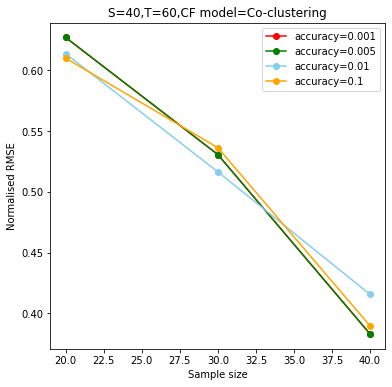

In [14]:
plt.figure(figsize=(6,6))
plt.plot(p1_co['sample_size'],p1_co['normalised_rmse'],color='red',label='accuracy=0.001',marker='o')
plt.plot(p2_co['sample_size'],p2_co['normalised_rmse'],color='green',label='accuracy=0.005',marker='o')
plt.plot(p3_co['sample_size'],p3_co['normalised_rmse'],color='skyblue',label='accuracy=0.01',marker='o')
plt.plot(p4_co['sample_size'],p4_co['normalised_rmse'],color='orange',label='accuracy=0.1',marker='o')
plt.xlabel('Sample size')
plt.ylabel('Normalised RMSE')
plt.title('S=40,T=60,CF model=Co-clustering')
plt.legend()
plt.show()

## different sample size

##### svd model

In [54]:
svd_20 = adapt(300,20,0.01,'svd')
svd_p_20 = predict_time('svd', m, n, r, svd_20, actual_rt, comp_svd)
print('svd_p_20',svd_p_20)
# svd_20_nrmse.append(svd_p_20_1['normalised_rmse'][0])
svd_40 = adapt(300,40,0.01,'svd')
svd_p_40 = predict_time('svd', m, n, r, svd_40, actual_rt, comp_svd)
print('svd_p_40',svd_p_40)

svd_60 = adapt(300,60,0.01,'svd')
svd_p_60 = predict_time('svd', m, n, r, svd_60, actual_rt, comp_svd)
print('svd_p_60',svd_p_60)

svd_80 = adapt(300,80,0.01,'svd')
svd_p_80 = predict_time('svd', m, n, r, svd_80, actual_rt, comp_svd)
print('svd_p_80',svd_p_80)

The final shedule {20: 10, 10: 10}
The final actual_dictionary: {20: [1.752802, 1.7846090000000001, 1.7400520000000002, 1.887304, 1.8699849999999998, 1.7037330000000002, 1.744201, 1.765466, 1.8204349999999998, 1.8205310000000001], 10: [0.484204, 0.47936999999999996, 0.467013, 0.429353, 0.455437, 0.5216649999999999, 0.451603, 0.465924, 0.47322700000000006, 0.457718]}
svd_p_20    sample_size  predicted_runtime_full_dataset  normalised_rmse
0           20                        24.82836         0.479437
The final shedule {40: 3, 30: 3, 20: 10, 10: 10}
The final actual_dictionary: {40: [7.691066999999999, 7.667486, 7.700385000000001], 30: [4.211626, 4.242529, 4.231962], 20: [1.7037330000000002, 1.744201, 1.887304, 1.8204349999999998, 1.752802, 1.8699849999999998, 1.7846090000000001, 1.7400520000000002, 1.8205310000000001, 1.765466], 10: [0.47936999999999996, 0.429353, 0.5216649999999999, 0.451603, 0.484204, 0.467013, 0.465924, 0.47322700000000006, 0.455437, 0.457718]}
svd_p_40    sample_si

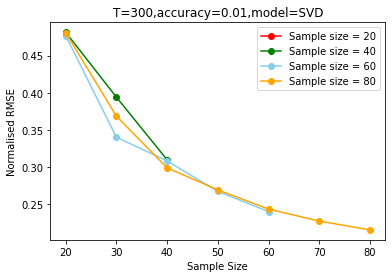

In [55]:
plt.title('T=300,accuracy=0.01,model=SVD')
plt.plot(svd_p_20['sample_size'],svd_p_20['normalised_rmse'],color='red',label='Sample size = 20',marker='o')
plt.plot(svd_p_40['sample_size'],svd_p_40['normalised_rmse'],color='green',label='Sample size = 40',marker='o')
plt.plot(svd_p_60['sample_size'],svd_p_60['normalised_rmse'],color='skyblue',label='Sample size = 60',marker='o')
plt.plot(svd_p_80['sample_size'],svd_p_80['normalised_rmse'],color='orange',label='Sample size = 80',marker='o')

plt.legend()
plt.xlabel('Sample Size')
plt.ylabel('Normalised RMSE')
plt.show()

##### baseline

The final shedule {20: 3, 10: 10}
The final actual_dictionary: {20: [0.09908600000000001, 0.098606, 0.098544], 10: [0.018813, 0.018941999999999997, 0.019656, 0.019617, 0.019672, 0.019293, 0.019237999999999998, 0.019614, 0.019455, 0.019443000000000002]}
baseline_p_20    sample_size  predicted_runtime_full_dataset  normalised_rmse
0           20                         1.58683         0.378065
The final shedule {40: 3, 30: 3, 20: 3, 10: 10}
The final actual_dictionary: {40: [0.365433, 0.365583, 0.359935], 30: [0.12925899999999999, 0.130385, 0.13132], 20: [0.09908600000000001, 0.098606, 0.098544], 10: [0.018813, 0.018941999999999997, 0.019656, 0.019617, 0.019672, 0.019293, 0.019237999999999998, 0.019614, 0.019455, 0.019443000000000002]}
baseline_p_40    sample_size  predicted_runtime_full_dataset  normalised_rmse
0           20                        1.586830         0.378065
1           30                        1.024515         0.598456
2           40                        1.419358    

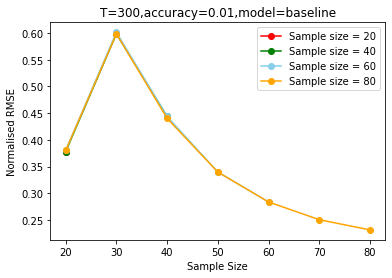

In [17]:
baseline_20 = adapt(300,20,0.01,'baseline')
baseline_p_20 = predict_time('baseline', m, n, r, baseline_20, actual_rt, comp_baseline)
print('baseline_p_20',baseline_p_20)
# svd_20_nrmse.append(svd_p_20_1['normalised_rmse'][0])
baseline_40 = adapt(300,40,0.01,'baseline')
baseline_p_40 = predict_time('baseline', m, n, r, baseline_40, actual_rt, comp_baseline)
print('baseline_p_40',baseline_p_40)

baseline_60 = adapt(300,60,0.01,'baseline')
baseline_p_60 = predict_time('baseline', m, n, r, baseline_60, actual_rt, comp_baseline)
print('baseline_p_60',baseline_p_60)

baseline_80 = adapt(300,80,0.01,'baseline')
baseline_p_80 = predict_time('baseline', m, n, r, baseline_80, actual_rt, comp_baseline)
print('baseline_p_80',baseline_p_80)

plt.title('T=300,accuracy=0.01,model=baseline')
plt.plot(baseline_p_20['sample_size'],baseline_p_20['normalised_rmse'],color='red',label='Sample size = 20',marker='o')
plt.plot(baseline_p_40['sample_size'],baseline_p_40['normalised_rmse'],color='green',label='Sample size = 40',marker='o')
plt.plot(baseline_p_60['sample_size'],baseline_p_60['normalised_rmse'],color='skyblue',label='Sample size = 60',marker='o')
plt.plot(baseline_p_80['sample_size'],baseline_p_80['normalised_rmse'],color='orange',label='Sample size = 80',marker='o')

plt.legend()
plt.xlabel('Sample Size')
plt.ylabel('Normalised RMSE')
plt.show()

##### NMF model

The final shedule {20: 10, 10: 3}
The final actual_dictionary: {20: [1.7026009999999998, 1.660134, 1.7023580000000003, 1.655218, 1.669371, 1.65777, 1.778943, 1.744434, 1.614781, 1.687775], 10: [0.459082, 0.463218, 0.456826]}
nmf_p_20    sample_size  predicted_runtime_full_dataset  normalised_rmse
0           20                       22.983751         0.513113
The final shedule {40: 10, 30: 10, 20: 10, 10: 3}
The final actual_dictionary: {40: [8.050094999999999, 7.546710000000001, 7.538053, 7.454207000000001, 7.700977000000001, 7.4049830000000005, 7.700622, 7.60233, 7.700157000000001, 7.767048], 30: [3.8059559999999997, 3.9692199999999995, 3.8635129999999998, 3.9523589999999995, 4.046638, 3.9368510000000003, 3.862229, 3.8620669999999997, 3.940381, 3.959307], 20: [1.7026009999999998, 1.660134, 1.7023580000000003, 1.655218, 1.669371, 1.65777, 1.778943, 1.744434, 1.614781, 1.687775], 10: [0.459082, 0.463218, 0.456826]}
nmf_p_40    sample_size  predicted_runtime_full_dataset  normalised_rms

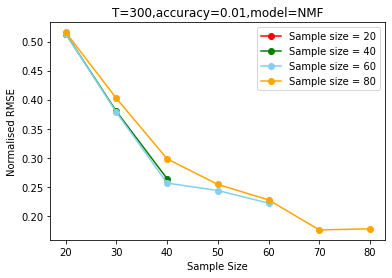

In [18]:
nmf_20 = adapt(300,20,0.01,'nmf')
nmf_p_20 = predict_time('nmf', m, n, r, nmf_20, actual_rt, comp_nmf)
print('nmf_p_20',nmf_p_20)

nmf_40 = adapt(300,40,0.01,'nmf')
nmf_p_40 = predict_time('nmf', m, n, r, nmf_40, actual_rt, comp_nmf)
print('nmf_p_40',nmf_p_40)

nmf_60 = adapt(300,60,0.01,'nmf')
nmf_p_60 = predict_time('nmf', m, n, r, nmf_60, actual_rt, comp_nmf)
print('nmf_p_60',nmf_p_60)

nmf_80 = adapt(300,80,0.01,'nmf')
nmf_p_80 = predict_time('nmf', m, n, r, nmf_80, actual_rt, comp_nmf)
print('nmf_p_80',nmf_p_80)

plt.title('T=300,accuracy=0.01,model=NMF')
plt.plot(nmf_p_20['sample_size'],nmf_p_20['normalised_rmse'],color='red',label='Sample size = 20',marker='o')
plt.plot(nmf_p_40['sample_size'],nmf_p_40['normalised_rmse'],color='green',label='Sample size = 40',marker='o')
plt.plot(nmf_p_60['sample_size'],nmf_p_60['normalised_rmse'],color='skyblue',label='Sample size = 60',marker='o')
plt.plot(nmf_p_80['sample_size'],nmf_p_80['normalised_rmse'],color='orange',label='Sample size = 80',marker='o')

plt.legend()
plt.xlabel('Sample Size')
plt.ylabel('Normalised RMSE')
plt.show()

##### coclustering

The final shedule {20: 3, 10: 3}
The final actual_dictionary: {20: [0.567479, 0.555107, 0.560311], 10: [0.18756, 0.190939, 0.187822]}
co_p_20    sample_size  predicted_runtime_full_dataset  normalised_rmse
0           20                        7.023874         0.609853
The final shedule {40: 3, 30: 10, 20: 3, 10: 3}
The final actual_dictionary: {40: [2.6041279999999998, 2.606566, 2.575149], 30: [1.189568, 1.242687, 1.2341010000000001, 1.244497, 1.237558, 1.259327, 1.219331, 1.246478, 1.238777, 1.23774], 20: [0.567479, 0.555107, 0.560311], 10: [0.18756, 0.190939, 0.187822]}
co_p_40    sample_size  predicted_runtime_full_dataset  normalised_rmse
0           20                        6.958113         0.613506
1           30                        8.706034         0.516416
2           40                       10.520484         0.415631
The final shedule {60: 10, 50: 3, 40: 3, 30: 10, 20: 3, 10: 3}
The final actual_dictionary: {60: [6.301348, 6.205063, 6.813811, 6.175774, 6.211194, 6.203065

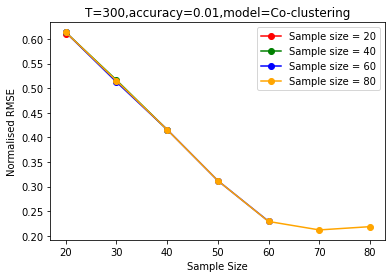

In [19]:
co_20 = adapt(300,20,0.01,'coclustering')
co_p_20 = predict_time('coclustering', m, n, r, co_20, actual_rt, comp_coclustering)
print('co_p_20',co_p_20)

co_40 = adapt(300,40,0.01,'coclustering')
co_p_40 = predict_time('coclustering', m, n, r, co_40, actual_rt, comp_coclustering)
print('co_p_40',co_p_40)

co_60 = adapt(300,60,0.01,'coclustering')
co_p_60 = predict_time('coclustering', m, n, r, co_60, actual_rt, comp_coclustering)
print('co_p_60',co_p_60)

co_80 = adapt(300,80,0.01,'coclustering')
co_p_80 = predict_time('coclustering', m, n, r, co_80, actual_rt, comp_coclustering)
print('co_p_80',co_p_80)

plt.title('T=300,accuracy=0.01,model=Co-clustering')
plt.plot(co_p_20['sample_size'],co_p_20['normalised_rmse'],color='red',label='Sample size = 20',marker='o')
plt.plot(co_p_40['sample_size'],co_p_40['normalised_rmse'],color='green',label='Sample size = 40',marker='o')
plt.plot(co_p_60['sample_size'],co_p_60['normalised_rmse'],color='blue',label='Sample size = 60',marker='o')
plt.plot(co_p_80['sample_size'],co_p_80['normalised_rmse'],color='orange',label='Sample size = 80',marker='o')

plt.legend()
plt.xlabel('Sample Size')
plt.ylabel('Normalised RMSE')
plt.show()

### different time budget